In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from arch import arch_model
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [2]:
# 1. Data Preparation
# ===================
df = pd.read_csv("CPI1.csv")
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df = df.sort_values("Date").reset_index(drop=True)


In [3]:
# Interpolate missing CPI values (including trailing NAs)
df["CPI"] = pd.to_numeric(df["CPI"], errors='coerce')
df["CPI"] = df["CPI"].interpolate(method='linear', limit_direction='both')

# Remove outliers (>3SD from mean)
mean, std = df["CPI"].mean(), df["CPI"].std()
df = df[(df["CPI"] < mean + 3*std) & (df["CPI"] > mean - 3*std)]

In [4]:
# Feature Engineering
df["Inflation_YoY"] = (df["CPI"] / df["CPI"].shift(12) - 1) * 100
df["Inflation_YoY_log"] = np.log(df["Inflation_YoY"].replace(0, np.nan))
df["Inflation_YoY_log_diff1"] = df["Inflation_YoY_log"].diff()

In [5]:
# Drop rows with NA (from lagging/differencing)
df = df.dropna(subset=["Inflation_YoY_log_diff1"]).reset_index(drop=True)

In [6]:
df.head()

,Date,CPI,Inflation_YoY,Inflation_YoY_log,Inflation_YoY_log_diff1
0,2001-02-01,10.2671,40.136491,3.692286,-0.019369
1,2001-03-01,10.6875,41.945466,3.736370,0.044084
2,2001-04-01,10.9499,39.492726,3.676117,-0.060254
3,2001-05-01,11.1439,37.921261,3.635512,-0.040605
4,2001-06-01,11.3201,36.835171,3.606453,-0.029059


In [7]:
# 2. Descriptive Statistics and Preliminary Data Analysis
# =======================================================

print("\nDescriptive statistics for CPI:")
print(df["CPI"].describe())
print("\nDescriptive statistics for YoY Inflation:")
print(df["Inflation_YoY"].describe())
print("\nSkewness and Kurtosis for YoY Inflation:")
print(f"Skewness: {df['Inflation_YoY'].skew():.3f}")
print(f"Kurtosis: {df['Inflation_YoY'].kurt():.3f}")
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nNumber of unique CPI values:", df["CPI"].nunique())



Descriptive statistics for CPI:
count    299.000000
mean      78.630738
std       66.813299
min       10.267100
25%       25.694900
50%       52.202900
75%      108.791200
max      260.500000
Name: CPI, dtype: float64

Descriptive statistics for YoY Inflation:
count    299.000000
mean      14.795970
std        7.034430
min        3.624648
25%        9.859690
50%       12.887294
75%       17.955279
max       41.945466
Name: Inflation_YoY, dtype: float64

Skewness and Kurtosis for YoY Inflation:
Skewness: 1.367
Kurtosis: 2.027

Missing values per column:
Date                       0
CPI                        0
Inflation_YoY              0
Inflation_YoY_log          0
Inflation_YoY_log_diff1    0
dtype: int64

Number of unique CPI values: 292


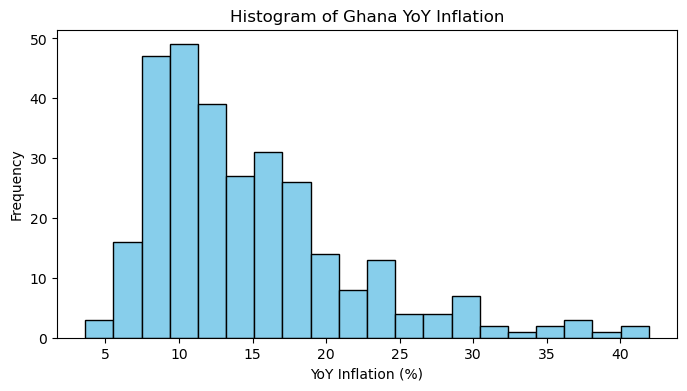

In [8]:
plt.figure(figsize=(8,4))
plt.hist(df["Inflation_YoY"], bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of Ghana YoY Inflation")
plt.xlabel("YoY Inflation (%)")
plt.ylabel("Frequency")
plt.show()


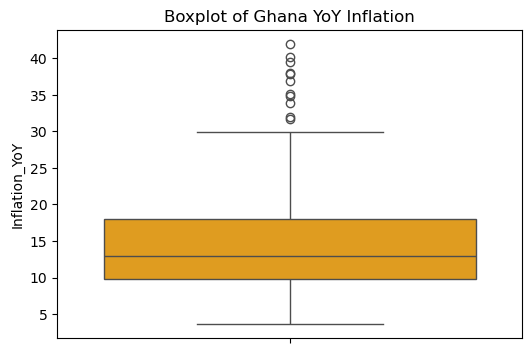

In [9]:
plt.figure(figsize=(6,4))
sns.boxplot(y=df["Inflation_YoY"], color='orange')
plt.title("Boxplot of Ghana YoY Inflation")
plt.show()

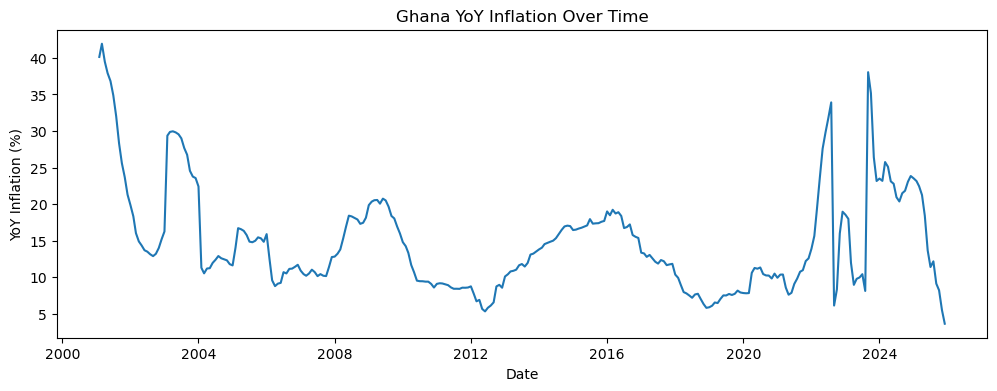

In [10]:
plt.figure(figsize=(12,4))
plt.plot(df["Date"], df["Inflation_YoY"])
plt.title("Ghana YoY Inflation Over Time")
plt.xlabel("Date")
plt.ylabel("YoY Inflation (%)")
plt.show()

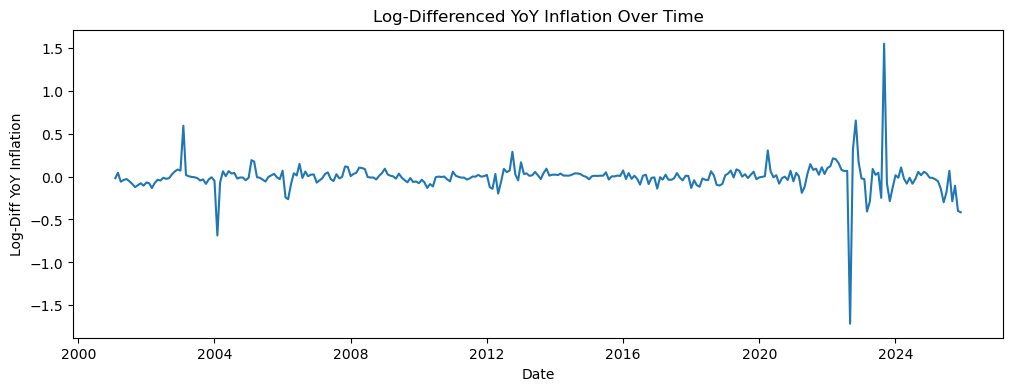

In [11]:
plt.figure(figsize=(12,4))
plt.plot(df["Date"], df["Inflation_YoY_log_diff1"])
plt.title("Log-Differenced YoY Inflation Over Time")
plt.xlabel("Date")
plt.ylabel("Log-Diff YoY Inflation")
plt.show()

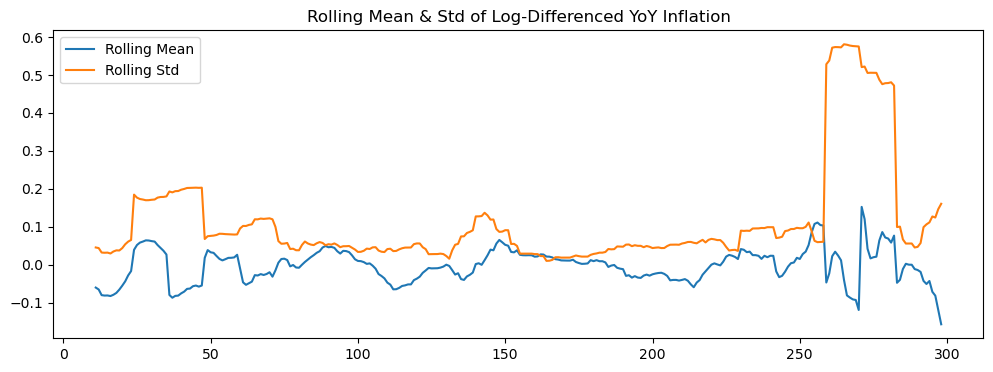

In [12]:
plt.figure(figsize=(12,4))
df["Inflation_YoY_log_diff1"].rolling(window=12).mean().plot(label="Rolling Mean")
df["Inflation_YoY_log_diff1"].rolling(window=12).std().plot(label="Rolling Std")
plt.legend()
plt.title("Rolling Mean & Std of Log-Differenced YoY Inflation")
plt.show()

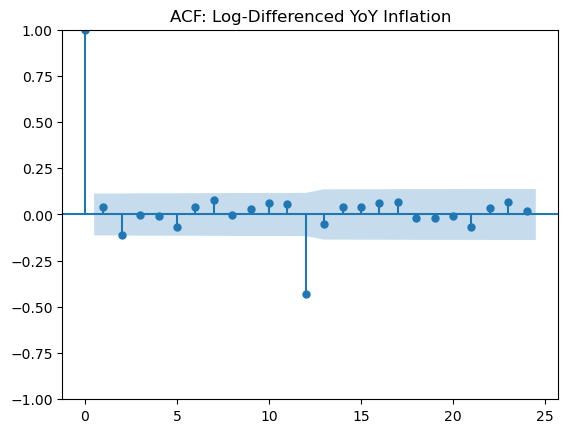

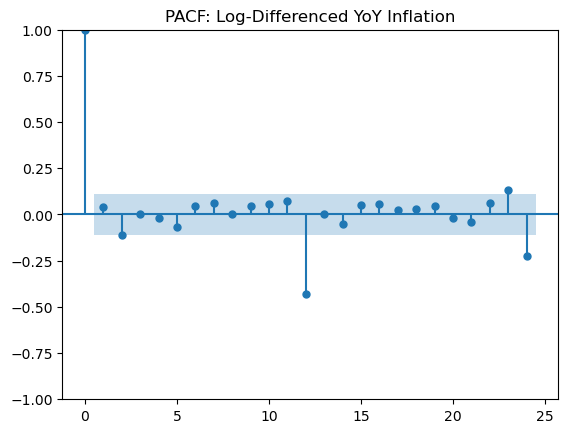

In [13]:
plot_acf(df["Inflation_YoY_log_diff1"].dropna(), lags=24)
plt.title("ACF: Log-Differenced YoY Inflation")
plt.show()
plot_pacf(df["Inflation_YoY_log_diff1"].dropna(), lags=24)
plt.title("PACF: Log-Differenced YoY Inflation")
plt.show()

In [14]:
# 3. Train-test split: Use 2023-01-01 as cutoff
train = df[df["Date"] < "2023-01-01"]
test = df[df["Date"] >= "2023-01-01"]

In [15]:
# 4. Stationarity Test
def stationarity_tests(series, name="Series"):
    adf_p = adfuller(series.dropna())[1]
    kpss_p = kpss(series.dropna(), nlags="auto")[1]
    print(f"\nStationarity Test for {name}:")
    print(f"ADF p-value: {adf_p:.3f}")
    print(f"KPSS p-value: {kpss_p:.3f}")

stationarity_tests(train["Inflation_YoY_log_diff1"], "Log-Diff YoY Inflation")


Stationarity Test for Log-Diff YoY Inflation:
ADF p-value: 0.000
KPSS p-value: 0.100


C:\Users\kojog\AppData\Local\Temp\ipykernel_18512\1674489311.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p = kpss(series.dropna(), nlags="auto")[1]


In [16]:
# 5. ARCH Effect Validation
from statsmodels.tsa.arima.model import ARIMA
arma_res = ARIMA(train["Inflation_YoY_log_diff1"], order=(1,0,1)).fit()
resid = arma_res.resid
arch_p = het_arch(resid**2, nlags=12)[1]
print(f"\nARCH-LM p-value: {arch_p:.3f}")


ARCH-LM p-value: 1.000


In [17]:
# 6. Model Specification & Forecasts (Ensemble)
# ==============================================
horizon = len(test)
train_y = train["Inflation_YoY_log_diff1"]
test_y = test["Inflation_YoY_log_diff1"].values


In [19]:
pip install pmdarima


   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------- ----------------------- 262.1/625.1 kB ? eta -:--:--
   --------------------------------- ------ 524.3/625.1 kB 2.4 MB/s eta 0:00:01
   ---------------------------------------- 625.1/625.1 kB 1.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.7 MB ? eta -:--:--
   ----------- ---------------------------- 0.8/2.7 MB 2.1 MB/s eta 0:00:01
   --------------- ------------------------ 1.0/2.7 MB 2.0 MB/s eta 0:00:01
   ------------------- -------------------- 1.3/2.7 MB 1.7 MB/s eta 0:00:01
   ------------------- -------------------- 1.3/2.7 MB 1.7 MB/s eta 0:00:01
   ----------------------- ---------------- 1.6/2.7 MB 1.3 MB/s eta 0:00:01
   --------------------------- ------------ 1.8/2.7 MB 1.3 MB/s eta 0:00:01
   --------------------------- ------------ 1.8/2.7 MB 1.3 MB/s eta 0:00:01
   -----------------------

In [20]:
# --- ARIMA Model 1 (auto) ---
from pmdarima import auto_arima
arima_fit1 = auto_arima(train_y, seasonal=False, stepwise=True, suppress_warnings=True)
fc_arima1 = arima_fit1.predict(n_periods=horizon)

In [21]:
# --- ARIMA Model 2 (manual ARIMA(1,0,1)) ---
arima_fit2 = ARIMA(train_y, order=(1,0,1)).fit()
fc_arima2 = arima_fit2.forecast(steps=horizon)


In [23]:
# Rescale your training and test data
scaling_factor = 100
train_y_scaled = train_y * scaling_factor

# Fit the GARCH model on the rescaled series
am_garch1 = arch_model(train_y_scaled, mean='AR', lags=1, vol='GARCH', p=1, q=1, dist='t')
garch_fit1 = am_garch1.fit(disp="off")
fc_garch1 = garch_fit1.forecast(horizon=horizon, start=None)
fc_garch1_mean_scaled = fc_garch1.mean.values[-1, :]

# Scale back the forecasts if you want to compare to the original scale
fc_garch1_mean = fc_garch1_mean_scaled / scaling_factor

In [25]:
# Fit EGARCH model (with rescaling, if needed)
scaling_factor = 100
train_y_scaled = train_y * scaling_factor
am_egarch = arch_model(train_y_scaled, mean='AR', lags=1, vol='EGARCH', p=1, q=1, dist='t')
egarch_fit = am_egarch.fit(disp="off")

# Forecast using simulation method for multi-step
fc_egarch = egarch_fit.forecast(horizon=horizon, method="simulation", random_state=42)
fc_egarch_mean_scaled = fc_egarch.mean.values[-1, :]

# Scale back to original
fc_egarch_mean = fc_egarch_mean_scaled / scaling_factor

In [32]:
from arch import arch_model

scaling_factor = 100
train_y_scaled = train_y * scaling_factor

# Fit GJR-GARCH(1,1) with AR(1) mean
am_gjrgarch = arch_model(train_y_scaled, mean='AR', lags=1, vol='GARCH', p=1, o=1, q=1, dist='t')
gjrgarch_fit = am_gjrgarch.fit(disp="off")

# Forecast multi-step (analytic is available for GJR-GARCH)
fc_gjrgarch = gjrgarch_fit.forecast(horizon=horizon, start=None)
fc_gjrgarch_mean_scaled = fc_gjrgarch.mean.values[-1, :]
fc_gjrgarch_mean = fc_gjrgarch_mean_scaled / scaling_factor

In [33]:
# Information Criteria Table for All Models

model_ics = []

# ARIMA_auto (pmdarima)
model_ics.append({
    "Model": "ARIMA_auto",
    "AIC": arima_fit1.aic(),
    "BIC": arima_fit1.bic()
})

# ARIMA_1_0_1 (statsmodels)
model_ics.append({
    "Model": "ARIMA(1,0,1)",
    "AIC": arima_fit2.aic,
    "BIC": arima_fit2.bic
})

# GARCH(1,1) with AR(1) mean (arch)
model_ics.append({
    "Model": "GARCH(1,1)",
    "AIC": garch_fit1.aic,
    "BIC": garch_fit1.bic
})

# EGARCH(1,1) with AR(1) mean (arch)
model_ics.append({
    "Model": "EGARCH(1,1)",
    "AIC": egarch_fit.aic,
    "BIC": egarch_fit.bic
})

# (Add GJR-GARCH if you fit it as gjrgarch_fit)
# model_ics.append({
#     "Model": "GJR-GARCH(1,1)",
#     "AIC": gjrgarch_fit.aic,
#     "BIC": gjrgarch_fit.bic
# })

# Display as DataFrame
import pandas as pd
info_criteria_df = pd.DataFrame(model_ics)
print("\nModel Information Criteria (lower is better):")
print(info_criteria_df)


Model Information Criteria (lower is better):
          Model          AIC          BIC
0    ARIMA_auto  -267.227403  -256.510941
1  ARIMA(1,0,1)  -265.306042  -251.017426
2    GARCH(1,1)  1741.795371  1763.205438
3   EGARCH(1,1)  1740.677174  1762.087241


In [34]:
# 7. Combine Forecasts (Ensemble)
forecast_df = pd.DataFrame({
    "ARIMA_auto": fc_arima1,
    "ARIMA_1_0_1": fc_arima2,
    "GARCH_1_1": fc_garch1_mean,
    "EGARCH_1_1": fc_egarch_mean,
    "GJRGARCH_1_1": fc_gjrgarch_mean,
    "Actual": test_y,
    "Date": test["Date"].values
})


In [35]:
forecast_df.head()

,ARIMA_auto,ARIMA_1_0_1,GARCH_1_1,EGARCH_1_1,GJRGARCH_1_1,Actual,Date
263,0.139565,0.136832,0.071071,0.069536,0.071803,-0.022082,2023-01-01
264,-0.116021,-0.118626,0.028680,0.027262,0.029386,-0.031099,2023-02-01
265,0.096450,0.093790,0.010677,0.009630,0.011229,-0.407051,2023-03-01
266,-0.080180,-0.082836,0.003032,0.002276,0.003456,-0.290594,2023-04-01
267,0.066654,0.064030,-0.000215,-0.000792,0.000128,0.087795,2023-05-01


In [36]:
# --- 1. Simple Average Ensemble ---
model_cols = ["ARIMA_auto", "ARIMA_1_0_1", "GARCH_1_1", "EGARCH_1_1", "GJRGARCH_1_1"]
forecast_df['Ensemble_Mean'] = forecast_df[model_cols].mean(axis=1)

In [38]:
from sklearn.metrics import root_mean_squared_error

rmses = []
for col in model_cols:
    rmse = root_mean_squared_error(forecast_df['Actual'], forecast_df[col])
    rmses.append(rmse)
inv_rmses = 1 / np.array(rmses)
weights = inv_rmses / inv_rmses.sum()
forecast_df['Ensemble_Weighted'] = forecast_df[model_cols].values @ weights

In [39]:
# --- 3. Stacking / Meta-Learner: Linear Regression ---
X_stack = forecast_df[model_cols].values
y_stack = forecast_df['Actual'].values
meta_lr = LinearRegression()
meta_lr.fit(X_stack, y_stack)
forecast_df['Ensemble_Stacking_LR'] = meta_lr.predict(X_stack)


In [40]:
# --- 4. Meta-Learner: Random Forest ---
meta_rf = RandomForestRegressor(n_estimators=100, random_state=0)
meta_rf.fit(X_stack, y_stack)
forecast_df['Ensemble_Stacking_RF'] = meta_rf.predict(X_stack)

In [41]:
# This will show all model columns, all ensemble columns, and Actual + Date
all_results_cols = ['Date', 'Actual'] + [col for col in forecast_df.columns if col not in ['Date', 'Actual']]
print(forecast_df[all_results_cols])

          Date    Actual  ARIMA_auto  ARIMA_1_0_1  GARCH_1_1  EGARCH_1_1  \
263 2023-01-01 -0.022082    0.139565     0.136832   0.071071    0.069536   
264 2023-02-01 -0.031099   -0.116021    -0.118626   0.028680    0.027262   
265 2023-03-01 -0.407051    0.096450     0.093790   0.010677    0.009630   
266 2023-04-01 -0.290594   -0.080180    -0.082836   0.003032    0.002276   
267 2023-05-01  0.087795    0.066654     0.064030  -0.000215   -0.000792   
268 2023-06-01  0.019435   -0.055410    -0.058091  -0.001593   -0.002071   
269 2023-07-01  0.043848    0.046063     0.043454  -0.002179   -0.002605   
270 2023-08-01 -0.249008   -0.038293    -0.040981  -0.002428   -0.002827   
271 2023-09-01  1.545690    0.031833     0.029228  -0.002533   -0.002920   
272 2023-10-01 -0.078454   -0.026463    -0.029152  -0.002578   -0.002959   
273 2023-11-01 -0.286999    0.021999     0.019391  -0.002597   -0.002975   
274 2023-12-01 -0.131172   -0.018288    -0.020973  -0.002605   -0.002982   
275 2024-01-

In [43]:
# --- 5. Evaluate All Ensembles ---
ensembles = ['Ensemble_Mean', 'Ensemble_Weighted', 'Ensemble_Stacking_LR', 'Ensemble_Stacking_RF']
for ens in ensembles:
    mae = np.mean(np.abs(forecast_df[ens] - forecast_df['Actual']))
    rmse = np.sqrt(np.mean((forecast_df[ens] - forecast_df['Actual']) ** 2))
    print(f"{ens}: MAE={mae:.2f}, RMSE={rmse:.2f}")

Ensemble_Mean: MAE=0.16, RMSE=0.31
Ensemble_Weighted: MAE=0.16, RMSE=0.31
Ensemble_Stacking_LR: MAE=0.16, RMSE=0.28
Ensemble_Stacking_RF: MAE=0.07, RMSE=0.13


In [45]:
# List all models (base + ensembles) to evaluate
eval_models = [
    'ARIMA_auto',
    'ARIMA_1_0_1',
    'GARCH_1_1',
    'EGARCH_1_1',
    'GJRGARCH_1_1',  # Uncomment if you have this
    'Ensemble_Mean',
    'Ensemble_Weighted',
    'Ensemble_Stacking_LR',
    'Ensemble_Stacking_RF'
]

results = []
for model in eval_models:
    mae = np.mean(np.abs(forecast_df[model] - forecast_df['Actual']))
    rmse = np.sqrt(np.mean((forecast_df[model] - forecast_df['Actual']) ** 2))
    results.append({'Model': model, 'MAE': mae, 'RMSE': rmse})

# Display as DataFrame
import pandas as pd
results_df = pd.DataFrame(results)
print("\nForecast evaluation (lower is better):")
print(results_df)


Forecast evaluation (lower is better):
                  Model       MAE      RMSE
0            ARIMA_auto  0.159897  0.307164
1           ARIMA_1_0_1  0.158935  0.306752
2             GARCH_1_1  0.161625  0.309491
3            EGARCH_1_1  0.161398  0.309387
4          GJRGARCH_1_1  0.161757  0.309550
5         Ensemble_Mean  0.158750  0.307882
6     Ensemble_Weighted  0.158736  0.307876
7  Ensemble_Stacking_LR  0.162356  0.280001
8  Ensemble_Stacking_RF  0.072272  0.128659


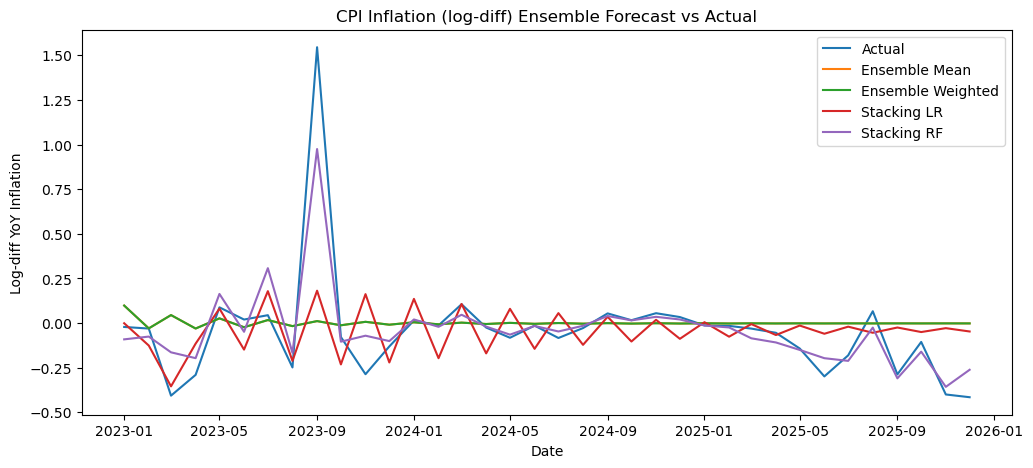

In [46]:
# --- 6. Visualization ---
plt.figure(figsize=(12,5))
plt.plot(forecast_df["Date"], forecast_df["Actual"], label="Actual")
plt.plot(forecast_df["Date"], forecast_df["Ensemble_Mean"], label="Ensemble Mean")
plt.plot(forecast_df["Date"], forecast_df["Ensemble_Weighted"], label="Ensemble Weighted")
plt.plot(forecast_df["Date"], forecast_df["Ensemble_Stacking_LR"], label="Stacking LR")
plt.plot(forecast_df["Date"], forecast_df["Ensemble_Stacking_RF"], label="Stacking RF")
plt.legend()
plt.title("CPI Inflation (log-diff) Ensemble Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Log-diff YoY Inflation")
plt.show()

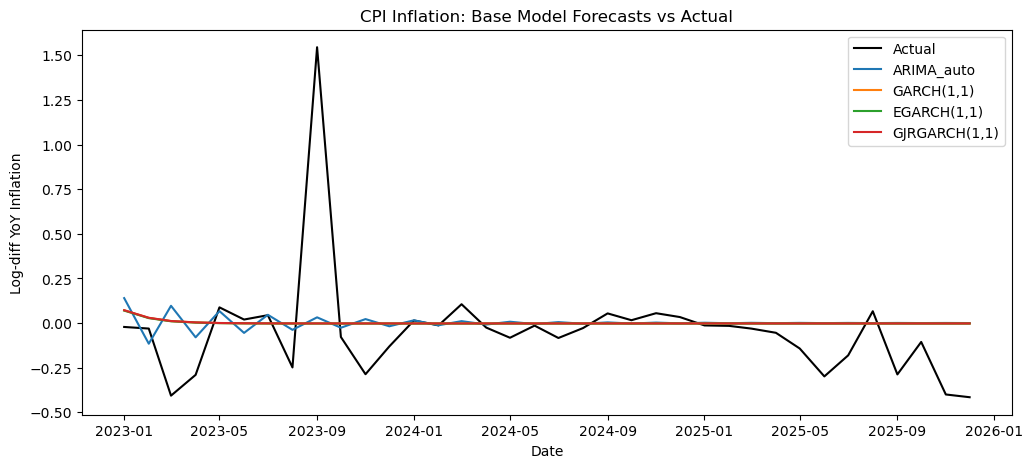

In [48]:
plt.figure(figsize=(12,5))
plt.plot(forecast_df["Date"], forecast_df["Actual"], label="Actual", color='black')
plt.plot(forecast_df["Date"], forecast_df["ARIMA_auto"], label="ARIMA_auto")
plt.plot(forecast_df["Date"], forecast_df["GARCH_1_1"], label="GARCH(1,1)")
plt.plot(forecast_df["Date"], forecast_df["EGARCH_1_1"], label="EGARCH(1,1)")
plt.plot(forecast_df["Date"], forecast_df["GJRGARCH_1_1"], label="GJRGARCH(1,1)")
plt.legend()
plt.title("CPI Inflation: Base Model Forecasts vs Actual")
plt.xlabel("Date")
plt.ylabel("Log-diff YoY Inflation")
plt.show()

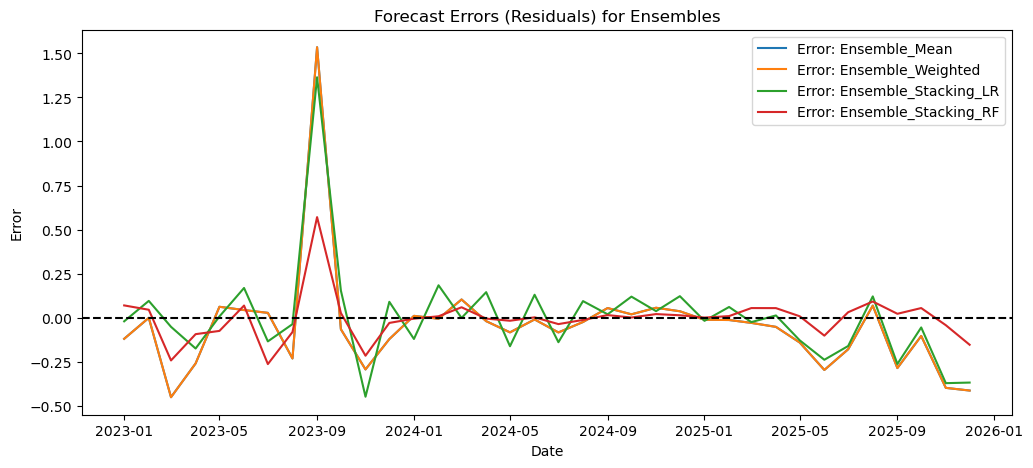

In [49]:
#prediction error plot
plt.figure(figsize=(12,5))
for col in ["Ensemble_Mean", "Ensemble_Weighted", "Ensemble_Stacking_LR", "Ensemble_Stacking_RF"]:
    plt.plot(forecast_df["Date"], forecast_df["Actual"] - forecast_df[col], label=f"Error: {col}")
plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.title("Forecast Errors (Residuals) for Ensembles")
plt.xlabel("Date")
plt.ylabel("Error")
plt.show()

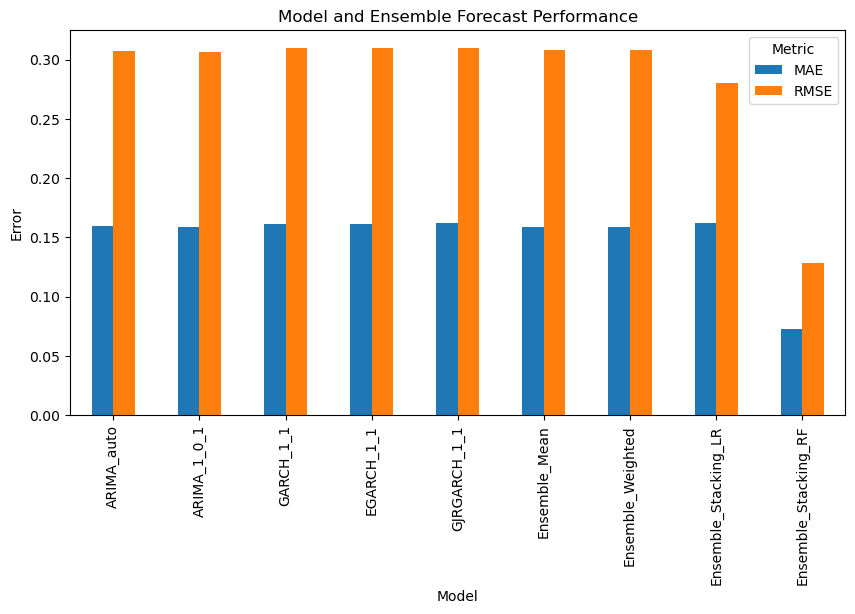

In [50]:
#Bar Plot of Model Performance (MAE, RMSE)
import matplotlib.pyplot as plt

# Assume results_df from previous answer
results_df.set_index('Model')[['MAE', 'RMSE']].plot(kind='bar', figsize=(10, 5))
plt.title("Model and Ensemble Forecast Performance")
plt.ylabel("Error")
plt.legend(title="Metric")
plt.show()

In [55]:
# --- 7. Save Results ---
forecast_df.to_csv("forecast_ensembles_univariate.csv", index=False)